# Analyze Simple Basel M1 fit

In [1]:
import torch as torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import *
import numpy as np
from os import path
import glob
from torch.nn.utils.rnn import *
from baselM1model import *
import tqdm

## Import the model

In [2]:
from fnmdataset import *

In [3]:
TEST_PATH = '/home/user/notebooks/data/test'
MODEL_PATH = '/home/user/notebooks/data/model/baselm1'
MODEL_SAVED = MODEL_PATH + '/baselm1.pth'

In [4]:
test_acq_numpy, test_idx_to_seq, test_seq_numpy = load_data(TEST_PATH)

Acquisition numpy: /home/user/notebooks/data/test/fnm_input_acq.npy
Sequence numpy: /home/user/notebooks/data/test/fnm_input_seq_*.npy
Index to Sequence Index numpy: /home/user/notebooks/data/test/fnm_input_idx_to_seq.npy
loading file: /home/user/notebooks/data/test/fnm_input_seq_0.npy


In [44]:
test_ds = FNMDataset(test_acq_numpy, test_idx_to_seq, test_seq_numpy)

In [11]:
BATCH_SIZE = 10000
NUM_WORKERS = 0
BATCH_SHOUT = 51

In [45]:
testDL = DataLoader(test_ds, batch_size=BATCH_SIZE, \
    collate_fn=paddingCollator, num_workers=NUM_WORKERS)

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BaselM1Model(11, 50, 5).to(device)
checkpoint = torch.load(MODEL_SAVED)
model.load_state_dict(checkpoint['model_state_dict'])

#if torch.cuda.device_count() > 1:
#    print("Training on", torch.cuda.device_count(), "GPUs")
#    model = nn.DataParallel(model)



IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [46]:
target_1y = []
predic_1y = []
dlq_source = []

In [47]:
model.eval()
tqdm_inner = tqdm.tqdm(testDL)
current_pred_idx = 0
for bidx, (seq, seq_len, acq, def1y) in enumerate(tqdm_inner):
    seq = seq.to(device)
    acq = acq.to(device)
    seq_len = seq_len.to(device)
    def1y = def1y.to(device)

    def1y_hat = model(seq, acq, seq_len, def1y)
    for s in range(def1y.shape[0]):
        target_1y.append(def1y[s, 0:seq_len[s]].cpu().detach().numpy().tolist())
        predic_1y.append(def1y_hat[s, 0:seq_len[s]].cpu().detach().numpy().tolist())
        dlq_one_hot = seq[s, 0:seq_len[s], 0:8].cpu().detach().numpy()
        dlq = np.argmax(dlq_one_hot, axis=1)
        dlq_source.append(dlq.tolist())    

100%|██████████| 255/255 [21:14<00:00,  3.85s/it]


In [51]:
print('len(target_1y)={:,}, len(predic_1y)={:,}, len(dlq)={:,}'.format(len(target_1y), len(predic_1y), len(dlq_source)))

len(target_1y)=2,541,990, len(predic_1y)=2,541,990, len(dlq)=2,541,990


In [55]:
target_1y_np = np.hstack(target_1y)
predic_1y_np = np.hstack(predic_1y)

In [56]:
dlq_source_np = np.hstack(dlq_source)

In [37]:
np.save(MODEL_PATH + '/target_1y.npy', target_1y_np)
np.save(MODEL_PATH + '/predic_1y.npy', predic_1y_np)

In [58]:
print('predic_1y_np:{:,}  target_1y_np:{:,}, dlq_source_np:{:,}'.format(predic_1y_np.shape[0], target_1y_np.shape[0], dlq_source_np.shape[0]))

predic_1y_np:169,288,303  target_1y_np:169,288,303, dlq_source_np:169,288,303


In [59]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [41]:
fpr, tpr, thresholds = roc_curve(target_1y_np[0:10, predic_1y_np)

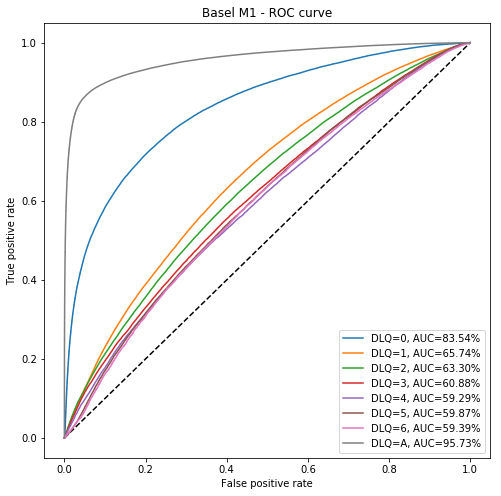

In [83]:
N = 100000
plt.figure(1, figsize=[8, 8])
plt.plot([0, 1], [0, 1], 'k--')
for dlq in range(7):
    idx = np.where(dlq_source_np==dlq)
    fpr, tpr, thresholds = roc_curve(target_1y_np[idx], predic_1y_np[idx])
    auc = roc_auc_score(target_1y_np[idx], predic_1y_np[idx])
    plt.plot(fpr, tpr, label='DLQ={}, AUC={:.2f}%'.format(dlq, auc*100))
fpr, tpr, thresholds = roc_curve(target_1y_np, predic_1y_np)
auc = roc_auc_score(target_1y_np, predic_1y_np)
plt.plot(fpr, tpr, label='DLQ=A, AUC={:.2f}%'.format(auc*100))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Basel M1 - ROC curve')
plt.legend(loc='best')
plt.savefig(MODEL_PATH+'/roc_curves.png', dpi=200)

# Show loss rates

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [27]:
checkpoint = torch.load(MODEL_SAVED)

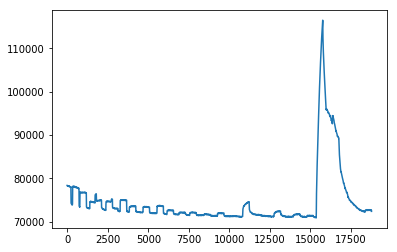

In [28]:
plt.plot(moving_average(checkpoint['train_losses'][1000:],400))

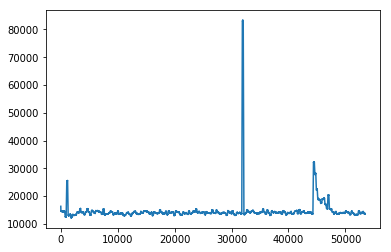

In [29]:
plt.plot(moving_average(checkpoint['valid_losses'][1000:], 100))

In [123]:
len(checkpoint['valid_losses'])

2295